In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [2]:
%pip install decorator==5.0.9

import imp
import numpy as np
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt
import networkx as nx
import seaborn as sns

Note: you may need to restart the kernel to use updated packages.


In [3]:
%pip install cltk==1.0.22

Note: you may need to restart the kernel to use updated packages.


In [46]:
# importing local modules

import sys
sys.path.append('../src/')

import text_cleanup.text_cleanup as thesisCleanUp
import preprocessing.text_preprocessing as thesisTextPreprocessing
import data.reader as thesisDataReader
import utils.utils as thesisUtils
import features.tf_idf.n_gram as thesisTfIdfNgramFeatures
import similarities.cosine as thesisCosineSimilarities
import vocabulary.vocabulary as thesisVocabulary
import features.lexical as thesisLexicalFeatures

imp.reload(thesisLexicalFeatures)
imp.reload(thesisCleanUp)
imp.reload(thesisTextPreprocessing)
imp.reload(thesisDataReader)
imp.reload(thesisUtils)
imp.reload(thesisTfIdfNgramFeatures)
imp.reload(thesisVocabulary)
imp.reload(thesisCosineSimilarities)

<module 'similarities.cosine' from '../src/similarities/cosine.py'>

# Data high level overview

Here we are looking at some properties of available data: like amount of paragraphs, words, characters, etc...


In [33]:
def data_high_level_overview():
    lexical_features_df = pd.concat([
        thesisLexicalFeatures.create_lexical_features_df(thesisDataReader.get_zwickau_corpus(), "zwickau"), 
        thesisLexicalFeatures.create_lexical_features_df(thesisDataReader.get_london_corpus(), "london"),
        thesisLexicalFeatures.create_lexical_features_df(thesisDataReader.get_breslau_corpus(), "breslau")
    ])

    display(lexical_features_df)
    lexical_features_df.plot(kind="barh", figsize=(15, 5), title='text lexical features with all replacers')
    
    lexical_features_df = pd.concat([
        thesisLexicalFeatures.create_lexical_features_df(thesisDataReader.get_zwickau_by_3_sentences(), "zwickau_3_sen"), 
        thesisLexicalFeatures.create_lexical_features_df(thesisDataReader.get_london_by_3_sentences(), "london_3_sen"),
        thesisLexicalFeatures.create_lexical_features_df(thesisDataReader.get_breslau_by_3_sentences(), "breslau_3_sen")
    ])


    display(lexical_features_df)
    lexical_features_df.plot(kind="barh", figsize=(15, 5), title='text lexical features with all replacers separated by 3 sentences')

,total_characters,total_words,unique_words,paragraphs,unique_lemmatized_word
zwickau,170609.0,26860.0,6063.0,321.0,4045.0
london,190575.0,30042.0,6509.0,317.0,4268.0
breslau,62525.0,9906.0,2953.0,71.0,2075.0


,total_characters,total_words,unique_words,paragraphs,unique_lemmatized_word
zwickau_3_sen,170609.0,26860.0,6063.0,397.0,4045.0
london_3_sen,190575.0,30042.0,6509.0,428.0,4268.0
breslau_3_sen,62525.0,9906.0,2953.0,121.0,2075.0


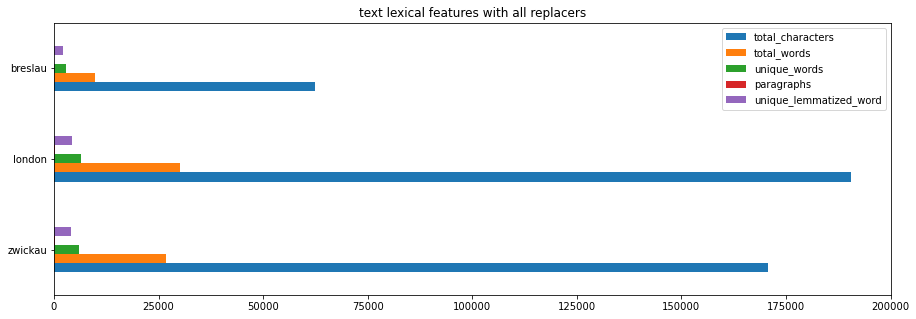

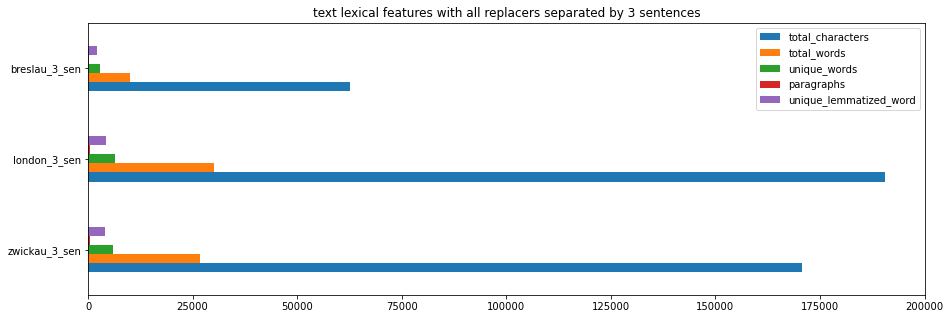

In [34]:
data_high_level_overview()

# Unique vocabulary
After our meeting 20.4, Yoni asked if we can have vocabulary of the words that appears in one version with counter bigger than 3 (for example) and does not appear in another 2 version

**UPDT**: cause unique vocabulary is very small for every version I choose threshold 1

In [49]:
def unique_vocabulary():
    df = thesisVocabulary.unique_vocabulary()
    df.to_csv('../computed_data/text_to_text/3_version_unique_vocabulary.csv')
    return df

In [48]:
unique_vocabulary()

,version,word,count
0,london,accepit,9
1,london,belonas,8
2,london,suanir,8
3,london,misit,7
4,london,aput,6
...,...,...,...
300,breslau,uiii,2
301,breslau,urbes,2
302,breslau,diuisionis,2
303,breslau,arsur,2


In [41]:
unique_vocabulary()

,version,word,count
0,london,accepit,9
1,london,belonas,8
2,london,suanir,8
3,london,misit,7
4,london,aput,6
...,...,...,...
300,breslau,uiii,2
301,breslau,urbes,2
302,breslau,diuisionis,2
303,breslau,arsur,2


# Shared vocabulary

Create vocabulary that shared in vesion a and b, but not in c - for all permutations

In [99]:
def shared_vocabulary():
    london_corpus = thesisDataReader.get_london_corpus()
    zwickau_corpus = thesisDataReader.get_zwickau_corpus()
    breslau_corpus = thesisDataReader.get_breslau_corpus()
    
    zwickau_london_shared_vocabulary = thesisVocabulary.get_shared_vocabulary_for_2_versions(
        zwickau_corpus, 'zwickau',
        london_corpus, 'london',
        breslau_corpus
    )
    london_zwickau_shared_vocabulary = thesisVocabulary.get_shared_vocabulary_for_2_versions(
        london_corpus, 'london',
        zwickau_corpus, 'zwickau',
        breslau_corpus
    )
    zwickau_breslau_shared_vocabulary = thesisVocabulary.get_shared_vocabulary_for_2_versions(
        zwickau_corpus, 'zwickau',
        breslau_corpus, 'breslau',
        london_corpus
    )
    london_breslau_shared_vocabulary = thesisVocabulary.get_shared_vocabulary_for_2_versions(
        london_corpus, 'london',
        breslau_corpus, 'breslau',
        zwickau_corpus
    )
    
    return [
        zwickau_london_shared_vocabulary,
        zwickau_breslau_shared_vocabulary,
        london_zwickau_shared_vocabulary,
        london_breslau_shared_vocabulary
    ]

def create_shared_vocabulary_df(shared_vocabulary):
    columns = [
        'shared_word', 
        'version a name', 
        'version a count',
        'version b name', 
        'version b count',
    ]
    all_data = []
    for shared_word in shared_vocabulary:
        data = [shared_word]
        
        for version_name in shared_vocabulary[shared_word]:
            data.append(version_name)
            data.append(shared_vocabulary[shared_word][version_name])
            
        all_data.append(data)
        
    return pd.DataFrame(all_data, columns=columns)

def create_shared_vocabulary_dfs():
    [
        zwickau_london_shared_vocabulary,
        zwickau_breslau_shared_vocabulary,
        london_zwickau_shared_vocabulary,
        london_breslau_shared_vocabulary
    ] = shared_vocabulary()
    
    zwickau_breslau_shared_vocabulary_df = create_shared_vocabulary_df(zwickau_breslau_shared_vocabulary)
    zwickau_breslau_shared_vocabulary_df.to_csv('../computed_data/text_to_text/vocabulary/shared_2_versions/zwickau_breslau.csv')
    display(zwickau_breslau_shared_vocabulary_df)
    
    london_zwickau_shared_vocabulary_df = create_shared_vocabulary_df(london_zwickau_shared_vocabulary)
    london_zwickau_shared_vocabulary_df.to_csv('../computed_data/text_to_text/vocabulary/shared_2_versions/london_zwickau.csv')
    display(london_zwickau_shared_vocabulary_df)
    
    london_breslau_shared_vocabulary_df = create_shared_vocabulary_df(london_breslau_shared_vocabulary)
    london_breslau_shared_vocabulary_df.to_csv('../computed_data/text_to_text/vocabulary/shared_2_versions/london_breslau.csv')
    display(london_breslau_shared_vocabulary_df)

In [100]:
create_shared_vocabulary_dfs()

,shared_word,version a name,version a count,version b name,version b count
0,sicud,zwickau,62,london,6
1,acon,zwickau,21,london,2
2,iacere,zwickau,14,london,19
3,crescunt,zwickau,13,london,12
4,plurimum,zwickau,13,london,9
...,...,...,...,...,...
2794,imaginatio,zwickau,1,london,1
2795,utinam,zwickau,1,london,1
2796,tenebris,zwickau,1,london,1
2797,occurrat,zwickau,1,london,1


,shared_word,version a name,version a count,version b name,version b count
0,lempna,zwickau,8,breslau,1
1,israhel,zwickau,6,breslau,4
2,corrosaim,zwickau,6,breslau,5
3,engadi,zwickau,5,breslau,3
4,ceila,zwickau,4,breslau,4
...,...,...,...,...,...
162,placuerit,zwickau,1,breslau,1
163,fures,zwickau,1,breslau,1
164,n,zwickau,1,breslau,1
165,io,zwickau,1,breslau,1


,shared_word,version a name,version a count,version b name,version b count
0,iacere,london,19,zwickau,14
1,longum,london,15,zwickau,10
2,oppidum,london,15,zwickau,1
3,ueni,london,15,zwickau,10
4,campo,london,13,zwickau,7
...,...,...,...,...,...
2794,terrere,london,1,zwickau,1
2795,margat,london,1,zwickau,2
2796,ualaniam,london,1,zwickau,1
2797,doram,london,1,zwickau,1


,shared_word,version a name,version a count,version b name,version b count
0,pilistiim,london,11,breslau,2
1,deinde,london,9,breslau,10
2,quatuor,london,8,breslau,4
3,acconensi,london,6,breslau,1
4,magedo,london,6,breslau,1
...,...,...,...,...,...
152,ueneratione,london,1,breslau,2
153,inquit,london,1,breslau,1
154,nouam,london,1,breslau,1
155,ramatam,london,1,breslau,1


# 5_gram split to 3 sentences

During last meeting 20.4 we saw that paragraphs that aligned together, has very different lenght (very short VS very long) we are thinking that it is happend because up till now we created corpus based on \n split, so we said that we will try to split each paragraph to 3 sentences, if paragraph is 4 or 5 sentences we will keep them together

In [25]:
london_corpus = thesisDataReader.get_london_by_3_sentences()
zwickau_corpus = thesisDataReader.get_zwickau_by_3_sentences()
breslau_corpus = thesisDataReader.get_breslau_by_3_sentences()

In [ ]:
zwickau_london_similarities = thesisCosineSimilarities.cross_version_similarity_5_gram(zwickau_corpus, london_corpus)
zwickau_breslau_similarities = thesisCosineSimilarities.cross_version_similarity_5_gram(zwickau_corpus, breslau_corpus)

london_zwickau_similarities = thesisCosineSimilarities.cross_version_similarity_5_gram(london_corpus, zwickau_corpus)
london_breslau_similarities = thesisCosineSimilarities.cross_version_similarity_5_gram(london_corpus, breslau_corpus)

breslau_zwickau_similarities = thesisCosineSimilarities.cross_version_similarity_5_gram(breslau_corpus, zwickau_corpus)
breslau_london_similarities = thesisCosineSimilarities.cross_version_similarity_5_gram(breslau_corpus, london_corpus)

In [ ]:
np.save('../computed_data/similarities/cross_version/sentences_by_3/zwickau_london_similarities.npy', zwickau_london_similarities)
np.save('../computed_data/similarities/cross_version/sentences_by_3/zwickau_breslau_similarities.npy', zwickau_breslau_similarities)

np.save('../computed_data/similarities/cross_version/sentences_by_3/london_zwickau_similarities.npy', london_zwickau_similarities)
np.save('../computed_data/similarities/cross_version/sentences_by_3/london_breslau_similarities.npy', london_breslau_similarities)

np.save('../computed_data/similarities/cross_version/sentences_by_3/breslau_zwickau_similarities.npy', breslau_zwickau_similarities)
np.save('../computed_data/similarities/cross_version/sentences_by_3/breslau_london_similarities.npy', breslau_london_similarities)

In [ ]:
zwickau_london_max_similarity_per_p = thesisUtils.get_max_similarity_per_p(zwickau_london_similarities)
zwickau_breslau_max_similarity_per_p = thesisUtils.get_max_similarity_per_p(zwickau_breslau_similarities)

london_zwickau_max_similarity_per_p = thesisUtils.get_max_similarity_per_p(london_zwickau_similarities)
london_breslau_max_similarity_per_p = thesisUtils.get_max_similarity_per_p(london_breslau_similarities)

breslau_zwickau_max_similarity_per_p = thesisUtils.get_max_similarity_per_p(breslau_zwickau_similarities)
breslau_london_max_similarity_per_p = thesisUtils.get_max_similarity_per_p(breslau_london_similarities)

In [ ]:
zwickau_breslau_best_smlrt = thesisCosineSimilarities.get_cross_version_best_similarities(zwickau_corpus, breslau_corpus)
zwickau_london_best_smlrt = thesisCosineSimilarities.get_cross_version_best_similarities(zwickau_corpus, london_corpus)

In [ ]:
london_breslau_best_smlrt = thesisCosineSimilarities.get_cross_version_best_similarities(london_corpus, breslau_corpus)
london_zwickau_best_smlrt = thesisCosineSimilarities.get_cross_version_best_similarities(london_corpus, zwickau_corpus)

In [ ]:
breslau_london_best_smlrt = thesisCosineSimilarities.get_cross_version_best_similarities(breslau_corpus, london_corpus)
breslau_zwickau_best_smlrt = thesisCosineSimilarities.get_cross_version_best_similarities(breslau_corpus, zwickau_corpus)

In [316]:
def create_5_gram_text_aligments(original_version, version_1, best_matches_1, version_2, best_matches_2):
    p_aligment = []
    
    for i, best_match_1 in enumerate(best_matches_1):
        best_match_2 = best_matches_2[i]
        
        best_match_1_p, best_match_1_score = best_match_1['5_gram']
        best_match_2_p, best_match_2_score = best_match_2['5_gram']
        
        data = [
            original_version[i],
            
            version_1[best_match_1_p],
            best_match_1_p,
            best_match_1_score,
        
            version_2[best_match_2_p],
            best_match_2_p,
            best_match_2_score
        ]
        
        p_aligment.append(data)
    return p_aligment

In [321]:
def create_zwickau_p_aligment():
    columns = [
        'zwickau text',
        'london text',
        'london p#',
        'score',
        'breslau text',
        'breslau p#',
        'score'
    ]
    p_aligment = create_5_gram_text_aligments(
        zwickau_corpus,
        london_corpus,
        zwickau_london_best_smlrt,
        breslau_corpus,
        zwickau_breslau_best_smlrt
    )
    return pd.DataFrame(p_aligment, columns=columns)
    

In [322]:
def create_london_p_aligment():
    columns = [
        'london text',
        'zwicau text',
        'zwicau p#',
        'score',
        'breslau text',
        'breslau p#',
        'score'
    ]
    p_aligment = create_5_gram_text_aligments(
        london_corpus,
        zwickau_corpus,
        london_zwickau_best_smlrt,
        breslau_corpus,
        london_breslau_best_smlrt
    )
    return pd.DataFrame(p_aligment, columns=columns)

In [323]:
def create_breslau_p_aligment():
    columns = [
        'breslau text',
        'zwicau text',
        'zwicau p#',
        'score',
        'london text',
        'london p#',
        'score'
    ]
    p_aligment = create_5_gram_text_aligments(
        breslau_corpus,
        zwickau_corpus,
        breslau_zwickau_best_smlrt,
        london_corpus,
        breslau_london_best_smlrt
    )
    return pd.DataFrame(p_aligment, columns=columns)

In [324]:
zwickau_p_aligment_df = create_zwickau_p_aligment()
london_p_aligment_df = create_london_p_aligment()
breslau_p_aligment_df = create_breslau_p_aligment()

In [328]:
zwickau_p_aligment_df.to_csv('../computed_data/p_aligment/sentences_by_3/zwickau_london_breslau.csv')
london_p_aligment_df.to_csv('../computed_data/p_aligment/sentences_by_3/london_zwickau_breslau.csv')
breslau_p_aligment_df.to_csv('../computed_data/p_aligment/sentences_by_3/breslau_london_zwickau.csv')

<AxesSubplot:title={'center':'zwickau p aligment similarity score (by new line)'}>

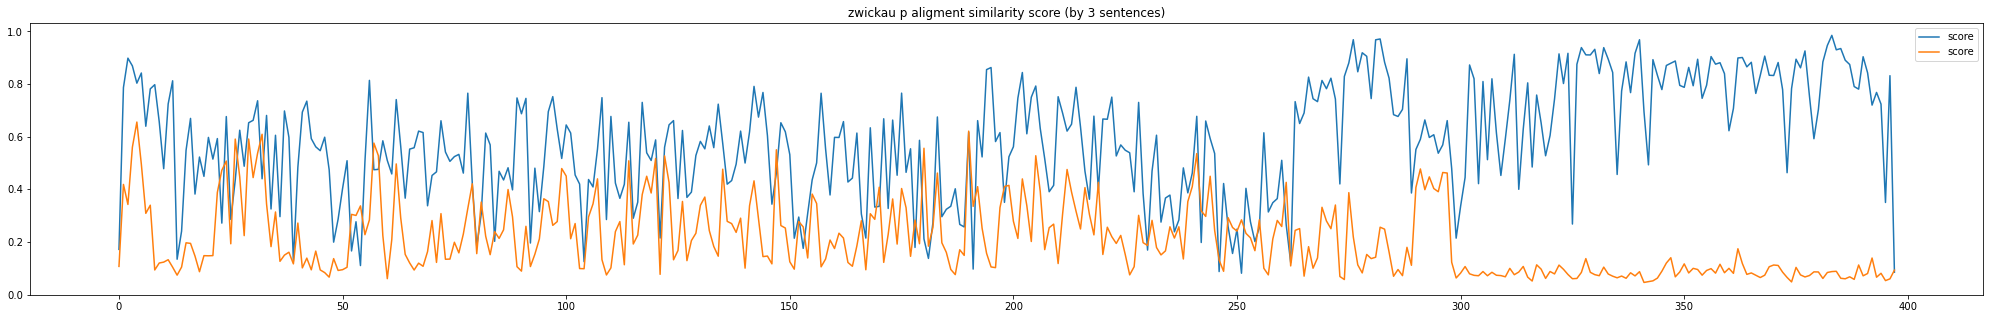

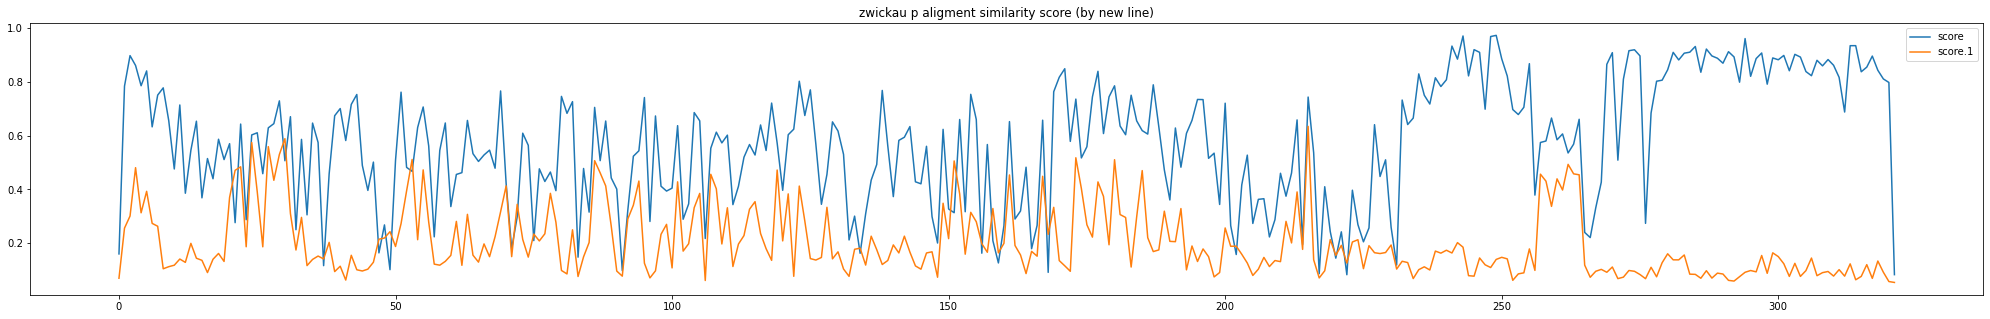

In [341]:
zwickau_p_aligment_df[['score']].plot(figsize=(35, 5), title='zwickau p aligment similarity score (by 3 sentences)')
pd.read_csv('../computed_data/p_aligment/zwickau_london_breslau.csv')[['score', 'score.1']].plot(figsize=(35, 5), title='zwickau p aligment similarity score (by new line)')

In [347]:
display(zwickau_p_aligment_df[['score']].describe())
display(pd.read_csv('../computed_data/p_aligment/zwickau_london_breslau.csv')[['score', 'score.1']].describe())

,score,score
count,398.000000,398.000000
mean,0.585381,0.208984
std,0.217803,0.137866
min,0.080867,0.045861
25%,0.428911,0.095024
50%,0.597498,0.161020
75%,0.764677,0.288636
max,0.984782,0.655319


,score,score.1
count,322.000000,322.000000
mean,0.576689,0.201493
std,0.226696,0.125397
min,0.082701,0.054012
25%,0.411374,0.105889
50%,0.601789,0.160958
75%,0.752913,0.263367
max,0.972249,0.633956


<AxesSubplot:title={'center':'zwickau p aligment similarity score (by new line)'}>

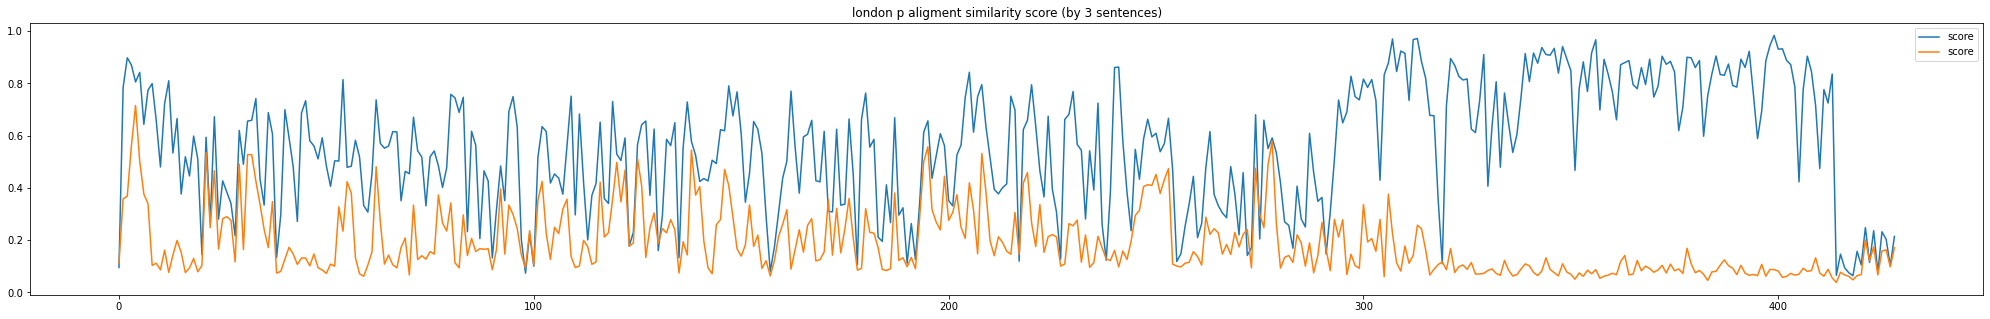

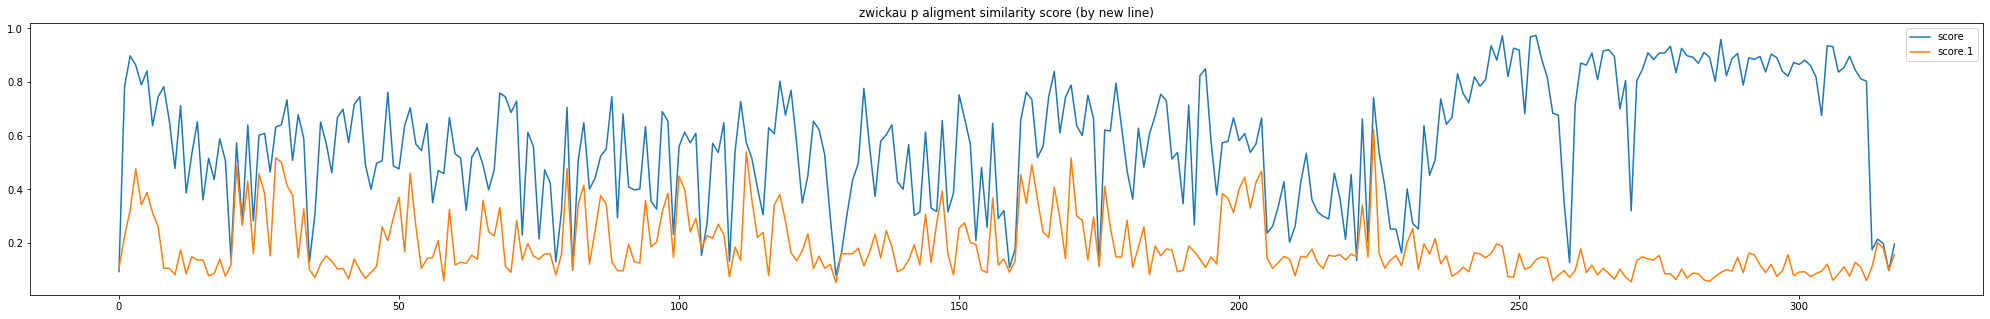

In [348]:
london_p_aligment_df[['score']].plot(figsize=(35, 5), title='london p aligment similarity score (by 3 sentences)')
pd.read_csv('../computed_data/p_aligment/london_zwickau_breslau.csv')[['score', 'score.1']].plot(figsize=(35, 5), title='london p aligment similarity score (by new line)')

In [350]:
display(london_p_aligment_df[['score']].describe())
display(pd.read_csv('../computed_data/p_aligment/london_zwickau_breslau.csv')[['score', 'score.1']].describe())

,score,score
count,429.000000,429.000000
mean,0.558384,0.188059
std,0.235038,0.124057
min,0.063867,0.038172
25%,0.380095,0.092306
50%,0.582675,0.145242
75%,0.749802,0.247741
max,0.984250,0.715724


,score,score.1
count,318.000000,318.000000
mean,0.580992,0.186445
std,0.226031,0.113091
min,0.080923,0.053676
25%,0.406627,0.105578
50%,0.606969,0.148378
75%,0.758824,0.234428
max,0.973818,0.623667


<AxesSubplot:title={'center':'breslau p aligment similarity score (by new line)'}>

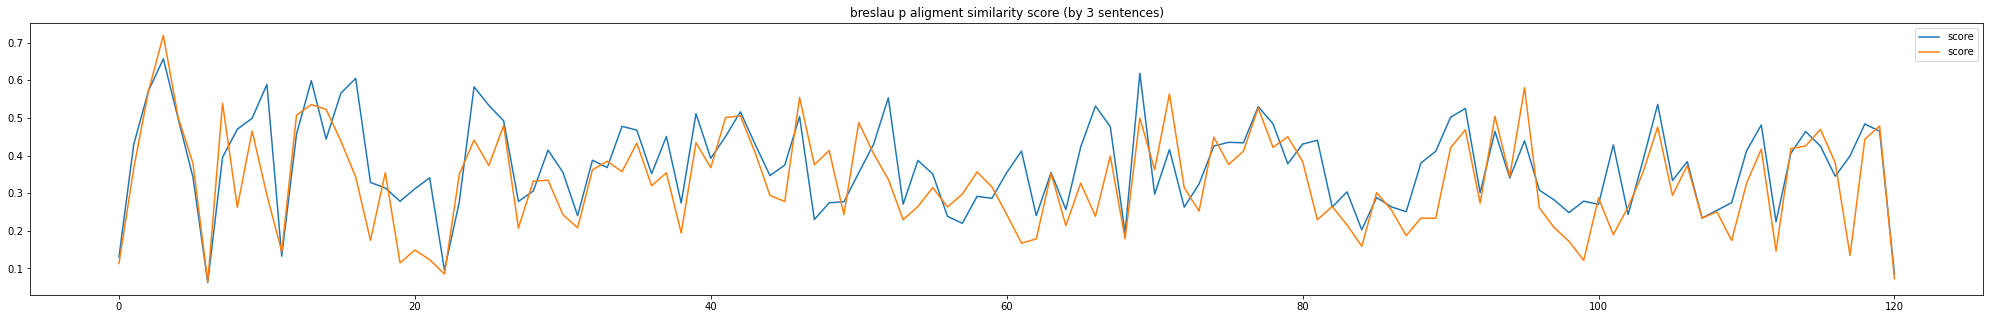

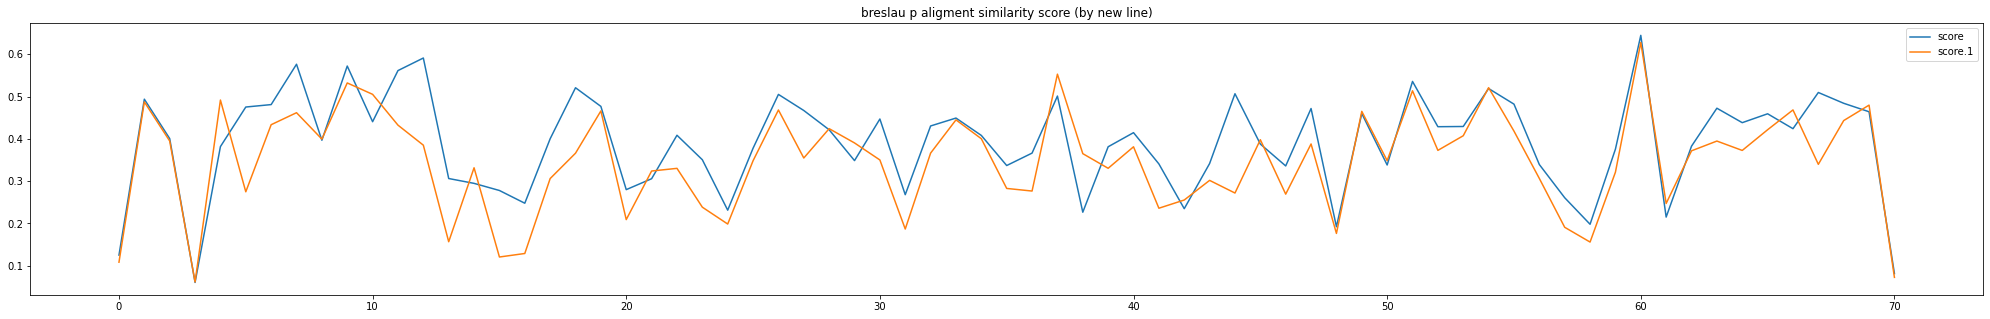

In [352]:
breslau_p_aligment_df[['score']].plot(figsize=(35, 5), title='breslau p aligment similarity score (by 3 sentences)')
pd.read_csv('../computed_data/p_aligment/breslau_london_zwickau.csv')[['score', 'score.1']].plot(figsize=(35, 5), title='breslau p aligment similarity score (by new line)')

In [354]:
display(breslau_p_aligment_df[['score']].describe())
display(pd.read_csv('../computed_data/p_aligment/breslau_london_zwickau.csv')[['score', 'score.1']].describe())

,score,score
count,121.000000,121.000000
mean,0.374885,0.331688
std,0.119760,0.129479
min,0.062598,0.064750
25%,0.278351,0.233570
50%,0.380183,0.336498
75%,0.463796,0.421772
max,0.657007,0.719391


,score,score.1
count,71.000000,71.000000
mean,0.390881,0.346706
std,0.119141,0.121027
min,0.060284,0.061426
25%,0.336308,0.273221
50%,0.407957,0.365997
75%,0.473754,0.428147
max,0.644676,0.627791


# Tests

In [36]:
imp.reload(thesisCleanUp)
%run ../src/text_cleanup/text_cleanup.test.py

.
----------------------------------------------------------------------
Ran 1 test in 0.003s

OK


In [37]:
imp.reload(thesisUtils)
%run ../src/utils/utils.test.py

.
----------------------------------------------------------------------
Ran 1 test in 0.001s

OK


In [87]:
imp.reload(thesisVocabulary)
%run ../src/vocabulary/vocabulary.test.py

.
----------------------------------------------------------------------
Ran 1 test in 0.003s

OK
